In [1]:
#import required libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split

In [2]:
#import and read csv files containing inputdata and labels

traindata=pd.read_csv('traindata_gray.csv')
traindata=traindata.drop(['Unnamed: 0'],axis=1)
labeldata=pd.read_csv('labeldata_gray.csv')
labeldata=labeldata.drop(['Unnamed: 0'],axis=1)

In [3]:
#split data into training and testing data with 8000 images in traindata and 2000 images in test data

X_train, X_test, Y_train, Y_test = train_test_split(traindata,labeldata, test_size=0.20, random_state=200)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(8000, 9216)
(8000, 2)
(2000, 9216)
(2000, 2)


In [4]:
#convert pandas dataframe to numpy matrix

X_train=X_train.as_matrix()
Y_train=Y_train.as_matrix()

X_test=X_test.as_matrix()
Y_test=Y_test.as_matrix()

In [6]:
#batches formed for input to cnn
X_train_batch=np.vsplit(X_train,64)
Y_train_batch=np.vsplit(Y_train,64)
X_test_batch=np.vsplit(X_test,20)
Y_test_batch=np.vsplit(Y_test,20)

#reshaping input data for each batch to feed to CNN
for i in range(0,64):
    X_train_batch[i]=X_train_batch[i].reshape(125,128,72,1)

for i in range(0,20):
    X_test_batch[i]=X_test_batch[i].reshape(100,128,72,1)    

In [7]:
print(X_train_batch[3].shape)
print(Y_train_batch[3].shape)
print(X_test_batch[3].shape)
print(Y_test_batch[3].shape)

(125, 128, 72, 1)
(125, 2)
(100, 128, 72, 1)
(100, 2)


In [8]:
#CNN model constructed for training of data

learning_rate = 0.0001
epochs = 30
n_classes = 2
dropout = 0.80

weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32],mean=0.0,stddev=1.0)),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64],mean=0.0,stddev=1.0)),
    'wd1': tf.Variable(tf.random_normal([32*18*64, 1024],mean=0.0,stddev=1.0)),
    'out': tf.Variable(tf.random_normal([1024, n_classes],mean=0.0,stddev=1.0))}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(x, weights, biases, dropout):
    # Layer 1 - 128*72*1 to 64*36*32
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2 - 64*36*32 to 32*18*64
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    
    # Fully connected layer - 32*18*64 to 1024
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output Layer - class prediction - 1024 to 2
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# tf Graph input
x = tf.placeholder(tf.float32, [None,128,72,1])
y = tf.placeholder(tf.float32, [None,n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model--output for each image
logits = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

saver = tf.train.Saver()
# Launch the graph

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        #batches in form of matrix
        for i in range(0,64) :
            batch_x = X_train_batch[i]
            batch_y = Y_train_batch[i]
        
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            print('Epoch : {:>2} --batch : {} --- Loss : {:>10.4f}'.format(epoch + 1,i+1,loss))
        
        test_acc_array=np.array([])
        for i in range(0,20) :
            batch_x_test = X_test_batch[i]
            batch_y_test = Y_test_batch[i]
            
            test_acc = sess.run(accuracy, feed_dict={
              x:batch_x_test,
              y:batch_y_test,
              keep_prob: 1.0})
            
            test_acc_array=np.append(test_acc_array,test_acc,axis=None)
    
        print('Testing Accuracy after epoch {} : {}'.format(epoch+1,np.mean(test_acc_array)))

    weights_updated = {
        'wc1_updated': tf.Variable(weights['wc1'],name='wc1_updated'),
        'wc2_updated': tf.Variable(weights['wc2'],name='wc2_updated'),
        'wd1_updated': tf.Variable(weights['wd1'],name='wd1_updated'),
        'w_out_updated': tf.Variable(weights['out'],name='w_out_updated')}

    biases_updated = {
        'bc1_updated': tf.Variable(biases['bc1'],name='bc1_updated'),
        'bc2_updated': tf.Variable(biases['bc2'],name='bc2_updated'),
        'bd1_updated': tf.Variable(biases['bd1'],name='bd1_updated'),
        'b_out_updated': tf.Variable(biases['out'],name='b_out_updated')}
    
    
    sess.run(tf.global_variables_initializer())
    #model to be saved in file
    saver = tf.train.Saver()
    save_path = saver.save(sess, "model/my_model")
    print("Model saved in file: %s" % save_path)

Epoch :  1 --batch : 1 --- Loss : 1841876.1250
Epoch :  1 --batch : 2 --- Loss : 455891.7500
Epoch :  1 --batch : 3 --- Loss : 24151.8594
Epoch :  1 --batch : 4 --- Loss : 322538.0625
Epoch :  1 --batch : 5 --- Loss : 11699.8838
Epoch :  1 --batch : 6 --- Loss : 100318.6641
Epoch :  1 --batch : 7 --- Loss : 43562.6797
Epoch :  1 --batch : 8 --- Loss : 18860.0449
Epoch :  1 --batch : 9 --- Loss : 12488.7471
Epoch :  1 --batch : 10 --- Loss : 11406.8965
Epoch :  1 --batch : 11 --- Loss :  8074.1431
Epoch :  1 --batch : 12 --- Loss :  9934.1777
Epoch :  1 --batch : 13 --- Loss :  6777.1875
Epoch :  1 --batch : 14 --- Loss :  5679.1177
Epoch :  1 --batch : 15 --- Loss :  5740.6191
Epoch :  1 --batch : 16 --- Loss :  5886.0952
Epoch :  1 --batch : 17 --- Loss :  5637.0659
Epoch :  1 --batch : 18 --- Loss :  4811.0757
Epoch :  1 --batch : 19 --- Loss :  5609.7310
Epoch :  1 --batch : 20 --- Loss :  3362.3115
Epoch :  1 --batch : 21 --- Loss :  3961.1973
Epoch :  1 --batch : 22 --- Loss :  28

Epoch :  3 --batch : 50 --- Loss :   103.9193
Epoch :  3 --batch : 51 --- Loss :   148.8828
Epoch :  3 --batch : 52 --- Loss :   140.9299
Epoch :  3 --batch : 53 --- Loss :   173.1594
Epoch :  3 --batch : 54 --- Loss :   122.6744
Epoch :  3 --batch : 55 --- Loss :   121.9677
Epoch :  3 --batch : 56 --- Loss :   203.8123
Epoch :  3 --batch : 57 --- Loss :   157.9661
Epoch :  3 --batch : 58 --- Loss :   150.9348
Epoch :  3 --batch : 59 --- Loss :    89.4984
Epoch :  3 --batch : 60 --- Loss :   101.0655
Epoch :  3 --batch : 61 --- Loss :   154.2438
Epoch :  3 --batch : 62 --- Loss :   123.2178
Epoch :  3 --batch : 63 --- Loss :   229.8693
Epoch :  3 --batch : 64 --- Loss :   130.5238
Testing Accuracy after epoch 3 : 0.891499999165535
Epoch :  4 --batch : 1 --- Loss :   244.0604
Epoch :  4 --batch : 2 --- Loss :   229.5084
Epoch :  4 --batch : 3 --- Loss :   170.8950
Epoch :  4 --batch : 4 --- Loss :   230.4446
Epoch :  4 --batch : 5 --- Loss :   124.1886
Epoch :  4 --batch : 6 --- Loss : 

Epoch :  6 --batch : 34 --- Loss :    46.1000
Epoch :  6 --batch : 35 --- Loss :    25.7924
Epoch :  6 --batch : 36 --- Loss :    70.7742
Epoch :  6 --batch : 37 --- Loss :    73.7456
Epoch :  6 --batch : 38 --- Loss :    61.6466
Epoch :  6 --batch : 39 --- Loss :    45.5113
Epoch :  6 --batch : 40 --- Loss :    53.3570
Epoch :  6 --batch : 41 --- Loss :    76.9157
Epoch :  6 --batch : 42 --- Loss :    58.2873
Epoch :  6 --batch : 43 --- Loss :    40.3445
Epoch :  6 --batch : 44 --- Loss :    70.5060
Epoch :  6 --batch : 45 --- Loss :    50.8888
Epoch :  6 --batch : 46 --- Loss :    62.6941
Epoch :  6 --batch : 47 --- Loss :    60.4961
Epoch :  6 --batch : 48 --- Loss :    72.3237
Epoch :  6 --batch : 49 --- Loss :    35.7877
Epoch :  6 --batch : 50 --- Loss :    21.0121
Epoch :  6 --batch : 51 --- Loss :    25.0647
Epoch :  6 --batch : 52 --- Loss :    49.8112
Epoch :  6 --batch : 53 --- Loss :   121.8275
Epoch :  6 --batch : 54 --- Loss :    48.5026
Epoch :  6 --batch : 55 --- Loss :

Epoch :  9 --batch : 18 --- Loss :    50.3489
Epoch :  9 --batch : 19 --- Loss :    56.0146
Epoch :  9 --batch : 20 --- Loss :    50.0206
Epoch :  9 --batch : 21 --- Loss :    66.3080
Epoch :  9 --batch : 22 --- Loss :    37.1684
Epoch :  9 --batch : 23 --- Loss :    33.5964
Epoch :  9 --batch : 24 --- Loss :    56.0866
Epoch :  9 --batch : 25 --- Loss :    31.7812
Epoch :  9 --batch : 26 --- Loss :    35.8332
Epoch :  9 --batch : 27 --- Loss :    42.7052
Epoch :  9 --batch : 28 --- Loss :    35.6516
Epoch :  9 --batch : 29 --- Loss :    25.9004
Epoch :  9 --batch : 30 --- Loss :    18.0213
Epoch :  9 --batch : 31 --- Loss :    49.0523
Epoch :  9 --batch : 32 --- Loss :    27.5188
Epoch :  9 --batch : 33 --- Loss :    20.0493
Epoch :  9 --batch : 34 --- Loss :    19.5399
Epoch :  9 --batch : 35 --- Loss :    20.4194
Epoch :  9 --batch : 36 --- Loss :    44.4429
Epoch :  9 --batch : 37 --- Loss :    40.4728
Epoch :  9 --batch : 38 --- Loss :    24.5212
Epoch :  9 --batch : 39 --- Loss :

Epoch : 12 --batch : 2 --- Loss :    41.0283
Epoch : 12 --batch : 3 --- Loss :    22.0141
Epoch : 12 --batch : 4 --- Loss :    38.9280
Epoch : 12 --batch : 5 --- Loss :    35.4495
Epoch : 12 --batch : 6 --- Loss :    43.8487
Epoch : 12 --batch : 7 --- Loss :    34.0771
Epoch : 12 --batch : 8 --- Loss :    16.4884
Epoch : 12 --batch : 9 --- Loss :    10.4192
Epoch : 12 --batch : 10 --- Loss :    26.5997
Epoch : 12 --batch : 11 --- Loss :    31.2943
Epoch : 12 --batch : 12 --- Loss :    41.0804
Epoch : 12 --batch : 13 --- Loss :    10.3539
Epoch : 12 --batch : 14 --- Loss :    30.2175
Epoch : 12 --batch : 15 --- Loss :    25.6306
Epoch : 12 --batch : 16 --- Loss :    12.2258
Epoch : 12 --batch : 17 --- Loss :    33.0541
Epoch : 12 --batch : 18 --- Loss :    29.6159
Epoch : 12 --batch : 19 --- Loss :    44.4187
Epoch : 12 --batch : 20 --- Loss :    34.2880
Epoch : 12 --batch : 21 --- Loss :    44.4627
Epoch : 12 --batch : 22 --- Loss :    26.1424
Epoch : 12 --batch : 23 --- Loss :    22.5

Epoch : 14 --batch : 51 --- Loss :    18.2008
Epoch : 14 --batch : 52 --- Loss :    25.0926
Epoch : 14 --batch : 53 --- Loss :    20.6474
Epoch : 14 --batch : 54 --- Loss :     6.5577
Epoch : 14 --batch : 55 --- Loss :     9.9160
Epoch : 14 --batch : 56 --- Loss :    24.7678
Epoch : 14 --batch : 57 --- Loss :     9.9547
Epoch : 14 --batch : 58 --- Loss :    24.4639
Epoch : 14 --batch : 59 --- Loss :    16.0395
Epoch : 14 --batch : 60 --- Loss :    12.8976
Epoch : 14 --batch : 61 --- Loss :    20.9344
Epoch : 14 --batch : 62 --- Loss :    30.0658
Epoch : 14 --batch : 63 --- Loss :    26.9472
Epoch : 14 --batch : 64 --- Loss :    18.2666
Testing Accuracy after epoch 14 : 0.9600000023841858
Epoch : 15 --batch : 1 --- Loss :    79.9108
Epoch : 15 --batch : 2 --- Loss :    25.6085
Epoch : 15 --batch : 3 --- Loss :    19.6654
Epoch : 15 --batch : 4 --- Loss :    32.3199
Epoch : 15 --batch : 5 --- Loss :    18.6398
Epoch : 15 --batch : 6 --- Loss :    32.3925
Epoch : 15 --batch : 7 --- Loss :

Epoch : 17 --batch : 35 --- Loss :    11.0372
Epoch : 17 --batch : 36 --- Loss :     6.7887
Epoch : 17 --batch : 37 --- Loss :    27.5630
Epoch : 17 --batch : 38 --- Loss :     3.9539
Epoch : 17 --batch : 39 --- Loss :    14.1496
Epoch : 17 --batch : 40 --- Loss :     7.5737
Epoch : 17 --batch : 41 --- Loss :    29.3986
Epoch : 17 --batch : 42 --- Loss :    13.3202
Epoch : 17 --batch : 43 --- Loss :     9.8301
Epoch : 17 --batch : 44 --- Loss :    33.2307
Epoch : 17 --batch : 45 --- Loss :     4.8674
Epoch : 17 --batch : 46 --- Loss :    13.4608
Epoch : 17 --batch : 47 --- Loss :    17.6167
Epoch : 17 --batch : 48 --- Loss :    18.1138
Epoch : 17 --batch : 49 --- Loss :    12.5647
Epoch : 17 --batch : 50 --- Loss :    10.2465
Epoch : 17 --batch : 51 --- Loss :    12.9876
Epoch : 17 --batch : 52 --- Loss :    30.1585
Epoch : 17 --batch : 53 --- Loss :    13.8440
Epoch : 17 --batch : 54 --- Loss :     4.8318
Epoch : 17 --batch : 55 --- Loss :    12.1389
Epoch : 17 --batch : 56 --- Loss :

Epoch : 20 --batch : 19 --- Loss :    23.0394
Epoch : 20 --batch : 20 --- Loss :    25.0556
Epoch : 20 --batch : 21 --- Loss :    42.1431
Epoch : 20 --batch : 22 --- Loss :    13.7640
Epoch : 20 --batch : 23 --- Loss :    18.0355
Epoch : 20 --batch : 24 --- Loss :    17.4375
Epoch : 20 --batch : 25 --- Loss :    16.1107
Epoch : 20 --batch : 26 --- Loss :    15.9994
Epoch : 20 --batch : 27 --- Loss :    20.9054
Epoch : 20 --batch : 28 --- Loss :    20.1852
Epoch : 20 --batch : 29 --- Loss :    12.9881
Epoch : 20 --batch : 30 --- Loss :    12.9847
Epoch : 20 --batch : 31 --- Loss :    15.8032
Epoch : 20 --batch : 32 --- Loss :    23.7711
Epoch : 20 --batch : 33 --- Loss :    13.7496
Epoch : 20 --batch : 34 --- Loss :     1.2473
Epoch : 20 --batch : 35 --- Loss :    11.2223
Epoch : 20 --batch : 36 --- Loss :     8.5538
Epoch : 20 --batch : 37 --- Loss :    19.5554
Epoch : 20 --batch : 38 --- Loss :     4.8395
Epoch : 20 --batch : 39 --- Loss :    14.0372
Epoch : 20 --batch : 40 --- Loss :

Epoch : 23 --batch : 3 --- Loss :    13.4107
Epoch : 23 --batch : 4 --- Loss :    23.0038
Epoch : 23 --batch : 5 --- Loss :     6.6978
Epoch : 23 --batch : 6 --- Loss :    13.5346
Epoch : 23 --batch : 7 --- Loss :    14.2701
Epoch : 23 --batch : 8 --- Loss :     6.7470
Epoch : 23 --batch : 9 --- Loss :     8.0659
Epoch : 23 --batch : 10 --- Loss :     6.8273
Epoch : 23 --batch : 11 --- Loss :     4.3015
Epoch : 23 --batch : 12 --- Loss :    25.7935
Epoch : 23 --batch : 13 --- Loss :     0.0000
Epoch : 23 --batch : 14 --- Loss :    10.9736
Epoch : 23 --batch : 15 --- Loss :    12.5810
Epoch : 23 --batch : 16 --- Loss :    10.0305
Epoch : 23 --batch : 17 --- Loss :    15.3282
Epoch : 23 --batch : 18 --- Loss :    16.9777
Epoch : 23 --batch : 19 --- Loss :    15.4946
Epoch : 23 --batch : 20 --- Loss :    16.3518
Epoch : 23 --batch : 21 --- Loss :    28.1067
Epoch : 23 --batch : 22 --- Loss :    14.4277
Epoch : 23 --batch : 23 --- Loss :    14.2523
Epoch : 23 --batch : 24 --- Loss :    23.

Epoch : 25 --batch : 52 --- Loss :    14.9964
Epoch : 25 --batch : 53 --- Loss :     9.4793
Epoch : 25 --batch : 54 --- Loss :     4.5509
Epoch : 25 --batch : 55 --- Loss :     6.0892
Epoch : 25 --batch : 56 --- Loss :    13.1147
Epoch : 25 --batch : 57 --- Loss :     0.8940
Epoch : 25 --batch : 58 --- Loss :    14.3060
Epoch : 25 --batch : 59 --- Loss :     8.2748
Epoch : 25 --batch : 60 --- Loss :     1.9267
Epoch : 25 --batch : 61 --- Loss :     4.7159
Epoch : 25 --batch : 62 --- Loss :    10.0880
Epoch : 25 --batch : 63 --- Loss :    13.4242
Epoch : 25 --batch : 64 --- Loss :     6.0413
Testing Accuracy after epoch 25 : 0.969500008225441
Epoch : 26 --batch : 1 --- Loss :    49.4212
Epoch : 26 --batch : 2 --- Loss :    13.5361
Epoch : 26 --batch : 3 --- Loss :     5.7621
Epoch : 26 --batch : 4 --- Loss :    24.2896
Epoch : 26 --batch : 5 --- Loss :     6.3085
Epoch : 26 --batch : 6 --- Loss :    11.9770
Epoch : 26 --batch : 7 --- Loss :    10.4402
Epoch : 26 --batch : 8 --- Loss :  

Epoch : 28 --batch : 36 --- Loss :     5.5416
Epoch : 28 --batch : 37 --- Loss :    15.5845
Epoch : 28 --batch : 38 --- Loss :     0.8267
Epoch : 28 --batch : 39 --- Loss :     6.5982
Epoch : 28 --batch : 40 --- Loss :     4.5715
Epoch : 28 --batch : 41 --- Loss :    15.5694
Epoch : 28 --batch : 42 --- Loss :    11.2593
Epoch : 28 --batch : 43 --- Loss :     6.9654
Epoch : 28 --batch : 44 --- Loss :    16.1390
Epoch : 28 --batch : 45 --- Loss :     1.7650
Epoch : 28 --batch : 46 --- Loss :     8.0739
Epoch : 28 --batch : 47 --- Loss :    11.2936
Epoch : 28 --batch : 48 --- Loss :    10.1193
Epoch : 28 --batch : 49 --- Loss :    11.6362
Epoch : 28 --batch : 50 --- Loss :     8.4934
Epoch : 28 --batch : 51 --- Loss :    10.1656
Epoch : 28 --batch : 52 --- Loss :    22.3855
Epoch : 28 --batch : 53 --- Loss :     5.4570
Epoch : 28 --batch : 54 --- Loss :     0.6856
Epoch : 28 --batch : 55 --- Loss :    11.4377
Epoch : 28 --batch : 56 --- Loss :    14.2677
Epoch : 28 --batch : 57 --- Loss :

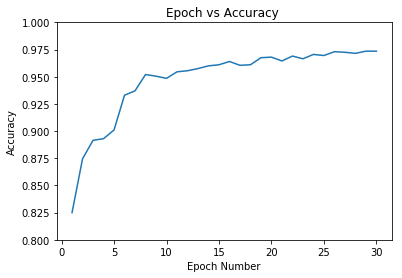

In [18]:
#plot of accuracy against epochs

import matplotlib.pyplot as plt
x=np.arange(1,31)
y=np.array([0.8250,0.8745,0.8915,0.8930,0.9010,0.9330,0.9370,0.9520,0.9505,0.9485,0.9545,0.9555,0.9575,0.9600,0.9610,0.9640,
            0.9605,0.9610,0.9675,0.9680,0.9645,0.9690,0.9665,0.9705,0.9695,0.9730,0.9725,0.9715,0.9735,0.9735
           ])
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy ")
plt.ylim([0.8,1])
plt.plot(x,y)
plt.show()